In [ ]:
library(ComplexHeatmap)
library(circlize)
library(viridis)
library(proxy)
library(seriation)
library(dendextend)
options(repr.plot.width=38, repr.plot.height=38)
library(dplyr)

In [2]:
#**! Paths where expression data (average expression, expression patterns, expression height), strain order,
#** regulons clusters, and phenotipic data are saved
path_expression='/home/karin/Documents/timeTrajectories/data/regulons/'
path_strain_order='/home/karin/Documents/timeTrajectories/data/'
path_phenotypes = '/home/karin/Documents/timeTrajectories/data/stages/'
path_abberant = '/home/karin/Documents/timeTrajectories/data/regulons/selected_genes/'

In [3]:
#**! Specify file names for regulons and expression
#** Expression tab file: Genes in columns (already scaled), averaged strain data in rows, 
#** three additional comlumns: Time, Strain, and Group (meaning strain group)
avg_expression=read.table(paste(path_expression,"genes_averaged_orange_scale99percentileMax0.1.tsv",sep=''),
                          header=TRUE,row.names=1, sep="\t")

#**! Specify file names for phenotipic data
#** Phenotypes tab file: Short averaged sample names in rows (as in avg_expression) and columns with phenotypes.
#** Phenotypes should have values: yes, no, no data
avg_phenotype=read.table(paste(path_phenotypes,"averageStages.tsv",sep=''),
                          header=TRUE,row.names=1, sep="\t", stringsAsFactors=FALSE)
#Change avg_phenotypes data so that each phenotype can be coloured differently
avg_phenotype[avg_phenotype=='no']=NA
for(col in colnames(avg_phenotype)){
  new_col=avg_phenotype[col]
  new_col[new_col=='yes']=col
  avg_phenotype[col]=new_col
}


#** Strain order - single column with ordered strain names
strain_order<-as.vector(read.table(paste(path_strain_order,"strain_order.tsv",sep=''))[,1])

In [4]:
#** Some plotting parameters
legend_font=12
phenotypes_font=10
legened_height=1.5
legend_width=0.7
top_annotation_height=0.6
phenotype_annotation_height=3
cluster_font=20

In [5]:
make_anno<-function(){

#Strain groups annotation
#** Colours of strain groups
group_cols=c('agg-'= '#ed1c24', 'lag_dis'= '#f97402','tag_dis'='#ffb100', 'tag'='#d9d800', 'cud'= '#008629', 'WT'= '#00b2ff',
                        'sFB'= '#1925ae', 'prec'='#a400d4' )
#group_cols_background=c('agg-'= '#cccccc', 'lag_dis'= '#666666','tag_dis'='#666666', 'tag'='#666666', 'cud'= '#cccccc', 
#                        'WT'= '#cccccc','sFB'= '#cccccc', 'prec'='#cccccc' )
group_cols_background=c('agg-'= 'white', 'lag_dis'= 'white','tag_dis'='#666666', 'tag'='#666666', 'cud'= 'white', 
                        'WT'= 'white','sFB'= 'white', 'prec'='white' )
group_cols_text=c('agg-'= 'black', 'lag_dis'= 'black','tag_dis'='black', 'tag'='black', 'cud'= '#eeeeee', 
                        'WT'= 'black','sFB'= '#eeeeee', 'prec'='#eeeeee' )

group_data=t(avg_expression['Group'])
rownames(group_data)<-c('Phenotypic group')            
# ht_list=Heatmap(group_data,show_column_names = FALSE, 
#                 height = unit(top_annotation_height, "cm"),
#                 column_split=factor(avg_expression$Strain,
#                                     #** Ordering of the strains in the heatmap (a vector of strain names)
#                                     #levels=unique(avg_expression$Strain)
#                                     levels=strain_order
#                 ),
#                 cluster_columns=FALSE,name='\nPhenotypic \ngroup\n',
#                 #** Strain name font size
#                 column_title_gp=gpar(fontsize=legend_font),
#                 col=group_cols, heatmap_legend_param = list( 
#                 grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
#                 labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
#                 row_names_gp = gpar(fontsize = cluster_font))

#Time annotation
times=unique(avg_expression$Time)
#** Time colours, group colours, and gaps
group_cols_ordered=c()
groups_ordered=c()
background_cols_ordered=c()
text_cols_ordered=c()
gaps=c()
previous_group=NULL
for(strain in strain_order){
  group=as.character(avg_expression[avg_expression$Strain==strain,'Group'][1])
  #print(paste(strain,group,group_cols[group]))
  groups_ordered<-append(groups_ordered,group)
  group_cols_ordered<-append(group_cols_ordered,group_cols[group])
  background_cols_ordered<-append(background_cols_ordered,group_cols_background[group])
  text_cols_ordered<-append(text_cols_ordered,group_cols_text[group])
  #Gaps - if previous group was different add larger gap; (N gaps = N-1 columns)
  if (!is.null(previous_group)){
    if (previous_group==group){ 
      gaps=append(gaps,1)
    }else{
      gaps=append(gaps,2.5)
    }
  }
  previous_group=group
}
gaps=unit(gaps,'mm')

col_time = colorRamp2( c(min(times),max(times)),c( "white", "#440154FF"))

ht_list=Heatmap(t(avg_expression['Time']), height = unit(top_annotation_height, "cm"),
                column_split=factor(avg_expression$Strain,
                #** Ordering of the strains in the heatmap (a vector of strain names)
                levels=strain_order ),
                column_title =NULL,column_gap=gaps,
                cluster_columns=FALSE, show_column_names = FALSE,name='\nTime\n',col=col_time,
                heatmap_legend_param = 
                list( at = c(min(times),as.integer(mean(c(min(times),max(times)))),max(times)),
                grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)
                    ),
                row_names_gp = gpar(fontsize = cluster_font),
                #column_title_gp=gpar(border =group_cols_ordered,fontsize=cluster_font,col =text_cols_ordered,fill=group_cols_ordered,
                #                     fontface='bold'),
                #Annotation for Phenotype group
                top_annotation = HeatmapAnnotation(
                  Phenotype=anno_block(gp = 
                                         # Background colour; fill: color, col: border                               
                                         #gpar(fill = '#949494',col='transparent'),
                                         #gpar(fill = 'white',col='transparent'),
                                         #gpar(fill = background_cols_ordered,col='transparent'),
                                         #gpar(fill = group_cols_ordered,col=group_cols_ordered),
                                         gpar(fill=group_cols_ordered,col=group_cols_ordered,lwd =2,linejoin='mitre'),
                                       labels = groups_ordered , labels_gp = gpar(col = 
                                                                                    # Text colour
                                                                                    # 'black',
                                                                                    #group_cols_ordered, 
                                                                                    text_cols_ordered,
                                                                                  fontsize = cluster_font
                                                                                  #,fontface='bold'
                                       ),
                                       #show_name = TRUE
                                      ) ,
                  Strain = anno_block(gp = 
                                            # Background colour; fill: color, col: border                               
                                            #gpar(fill = '#949494',col='transparent'),
                                            #gpar(fill = 'white',col='transparent'),
                                            #gpar(fill = background_cols_ordered,col='transparent'),
                                            #gpar(fill = group_cols_ordered,col=group_cols_ordered),
                                              gpar(fill='white',col=group_cols_ordered,lwd =2,linejoin='mitre'),
                        labels = strain_order , labels_gp = gpar(col = 
                                                                    # Text colour
                                                                   'black',
                                                                    #group_cols_ordered, 
                                                                    #text_cols_ordered,
                                                                    fontsize = cluster_font
                                                                  #,fontface='bold'
                                                                  ), 
                                      #show_name = TRUE
                                     ),
                annotation_name_gp=gpar(fontsize = cluster_font)
                        )
                )
#ht_list=ht_list %v% ht_time

#Phenotype annotation
#** Colours of phenotype annotations
phenotype_cols=c('no image'= '#d9d9d9', 'no_agg'= '#ed1c24', 'stream'= '#985006', 'lag'= '#f97402', 'tag'= '#d9d800', 'tip'= '#66cf00',
  'slug'= '#008629', 'mhat'= '#00c58f', 'cul'= '#0ff2ff', 'FB'= '#00b2ff', 'yem'='#666666')
#phenotype_cols=c('no data'= '#d9d9d9', 'yes'= '#74cf19', 'no'='#b54c4c')
ht_phenotype=Heatmap(t(avg_phenotype)[,rownames(avg_expression)], height = unit(phenotype_annotation_height, "cm"),
                cluster_columns=FALSE,cluster_rows=FALSE, show_column_names = FALSE,name='\nMorphological \nstage\n',col=phenotype_cols,
                row_names_gp = gpar(fontsize = phenotypes_font), na_col = "white",
                row_title ='Morphological stage',row_title_side ='right',row_title_gp=gpar(fontsize = cluster_font),
                heatmap_legend_param = list( grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                                             labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)))
ht_list=ht_list %v% ht_phenotype
    
return(ht_list)
}

In [6]:
stage_order<-colnames(avg_phenotype)
expressions<-within(avg_expression, rm('Time', 'Strain','Group'))
min_expression<-min(expressions)
max_expression<-max(expressions)

## Genes abberantly expressed in strain groups
Genes whose AX4-based closest neighbours are close to the gene in all WT strains, but not in strains of other strain groups. 

In [143]:
FDR=0.01
MEDIFF=0.2

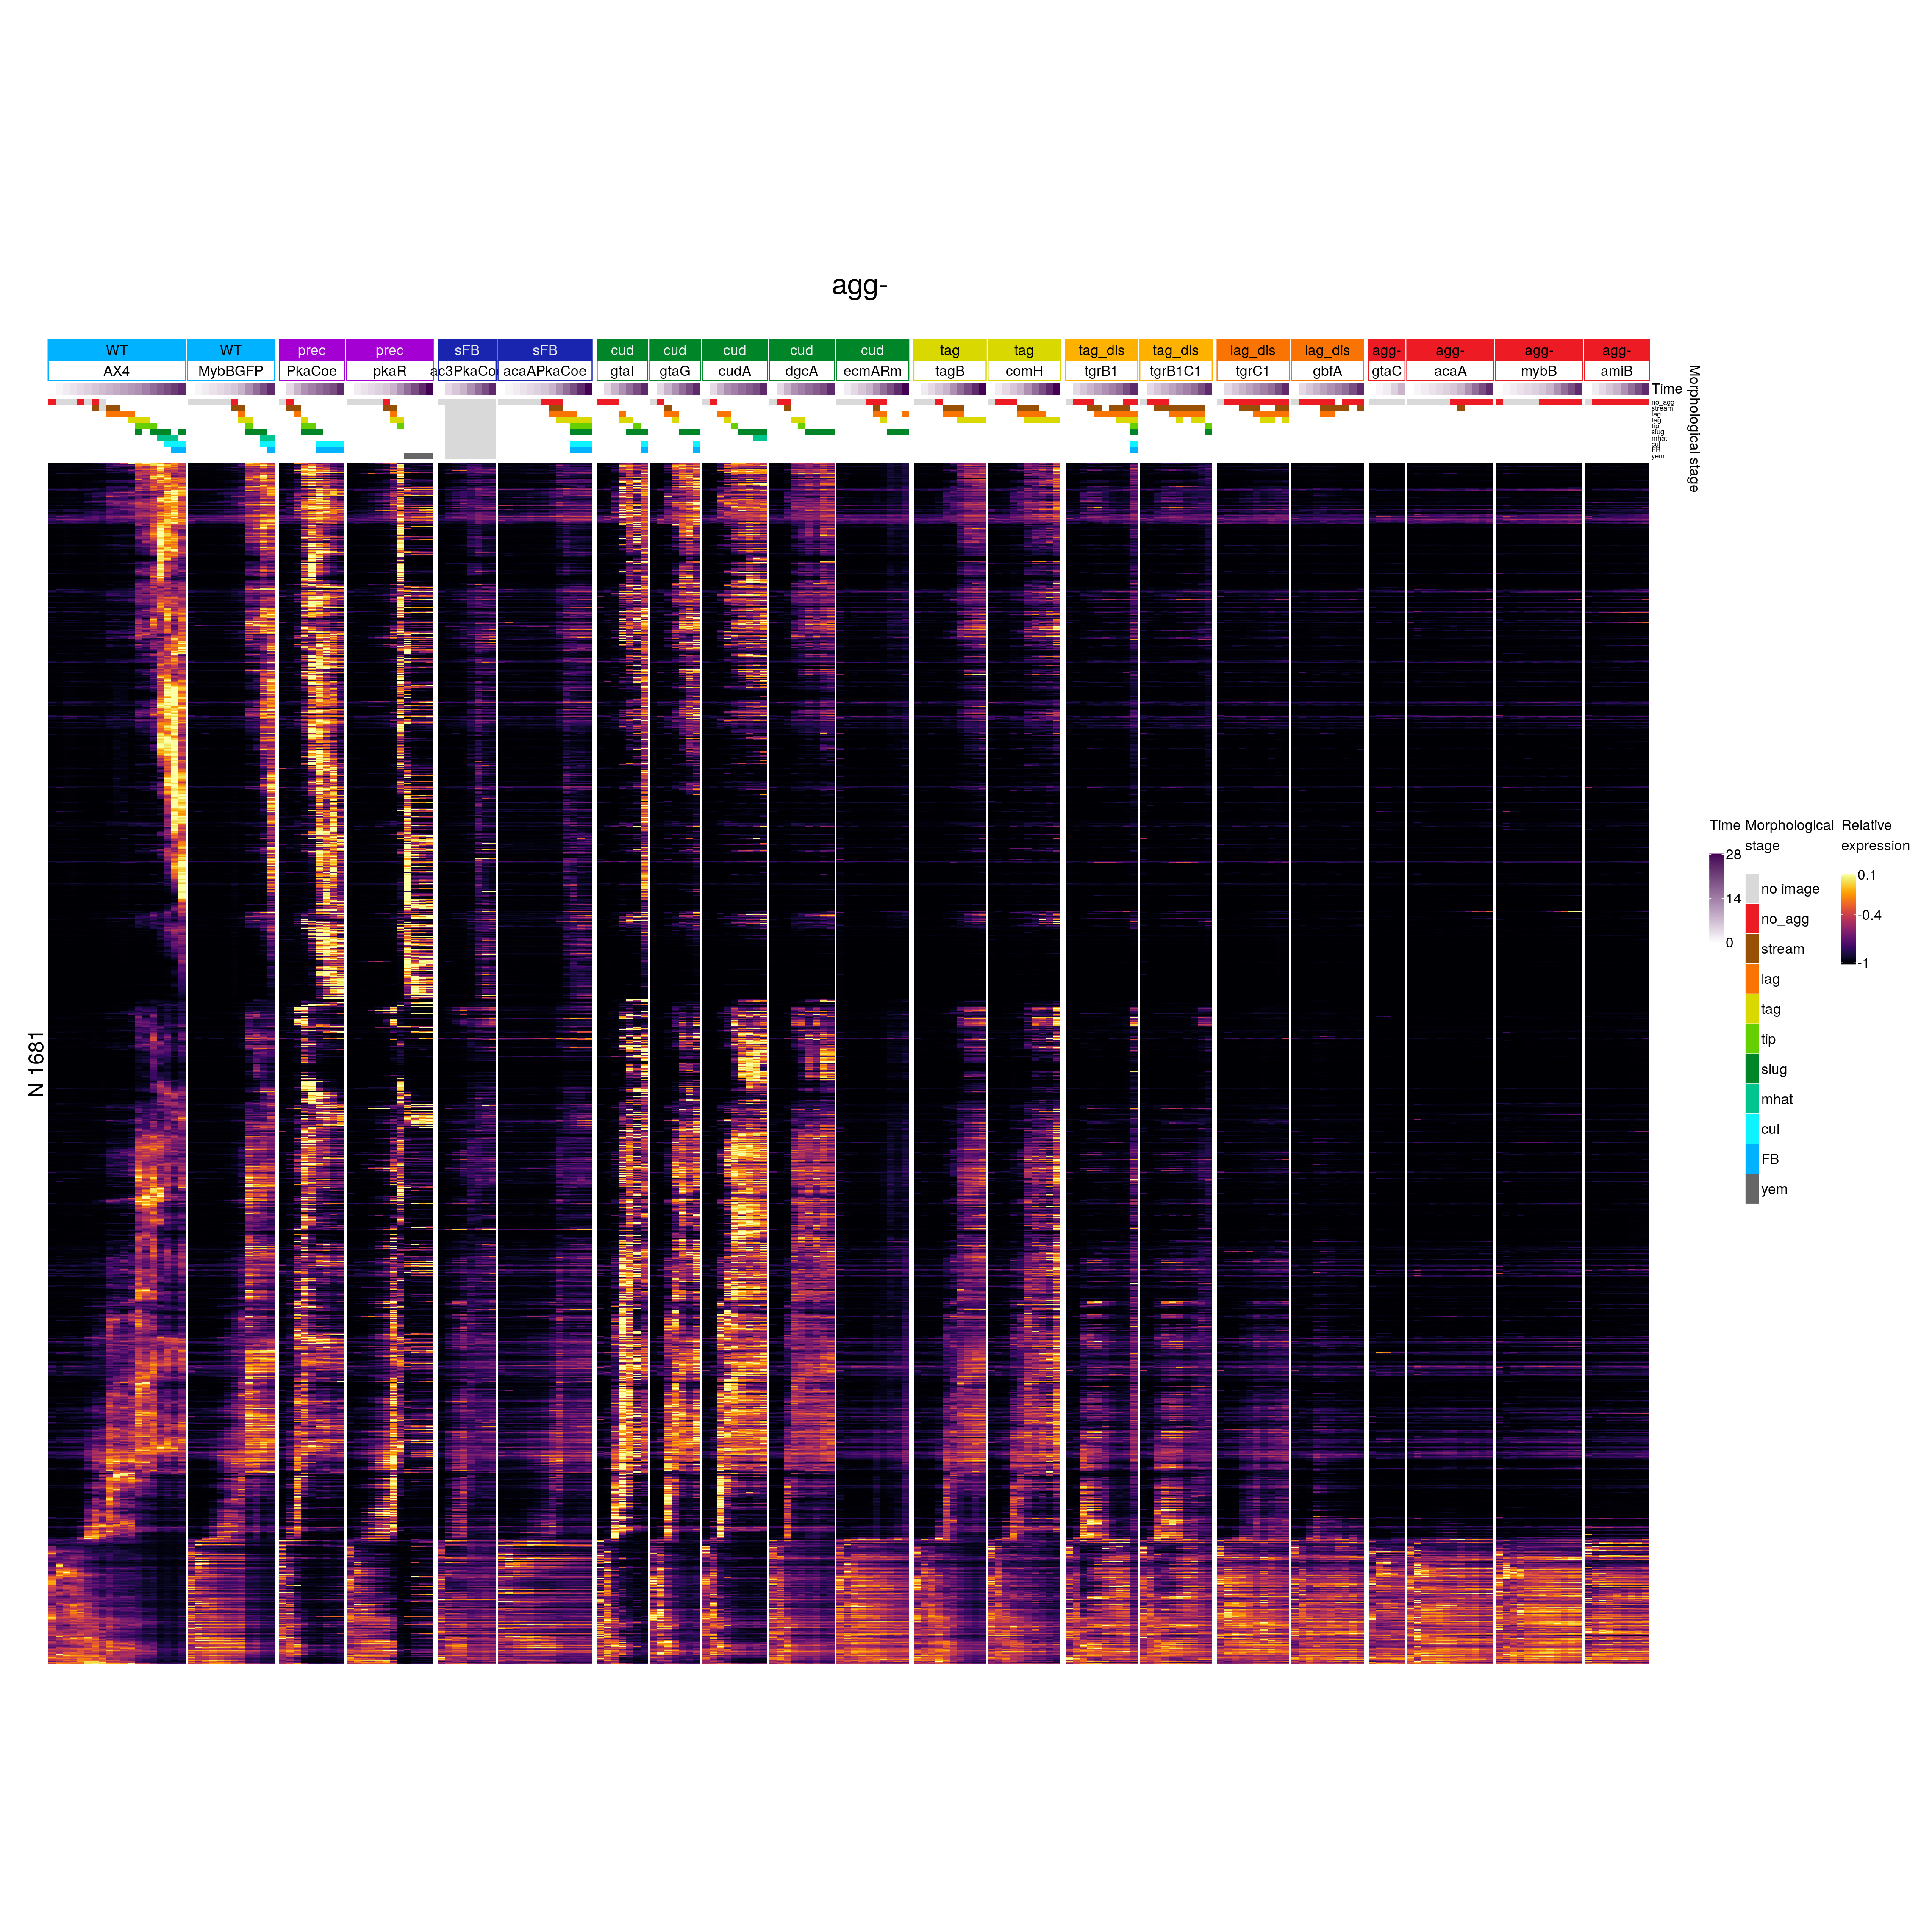

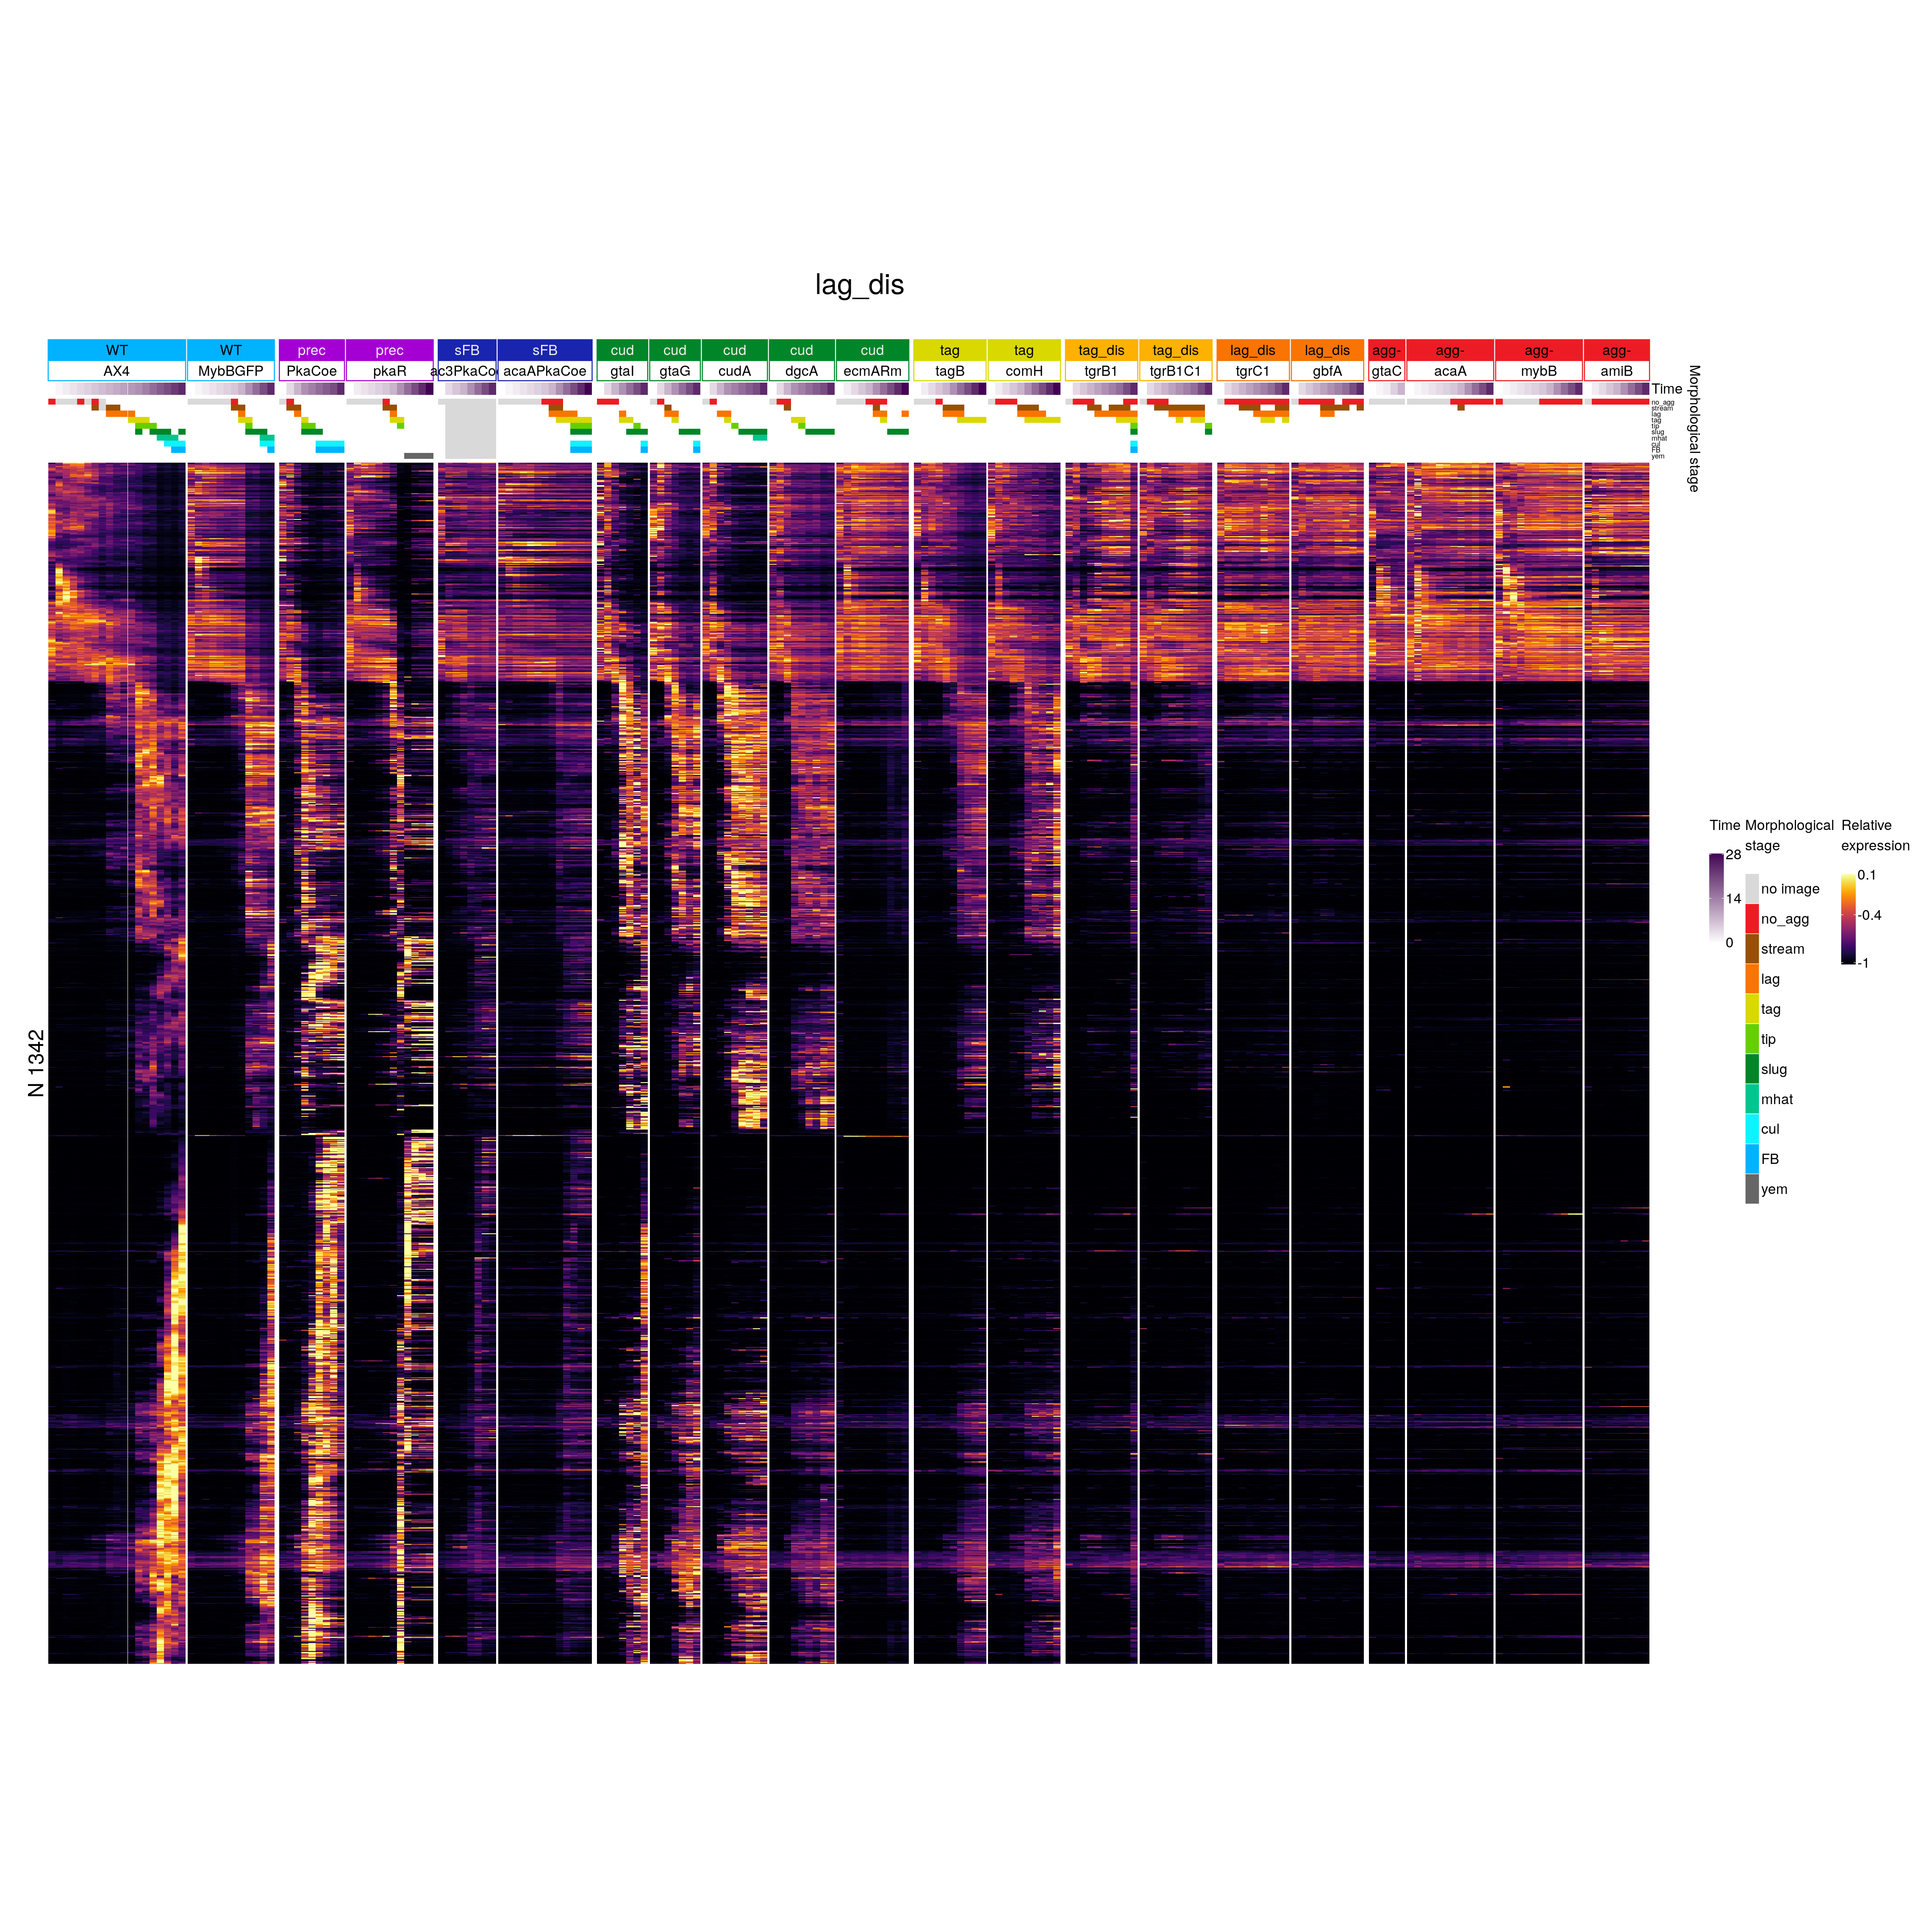

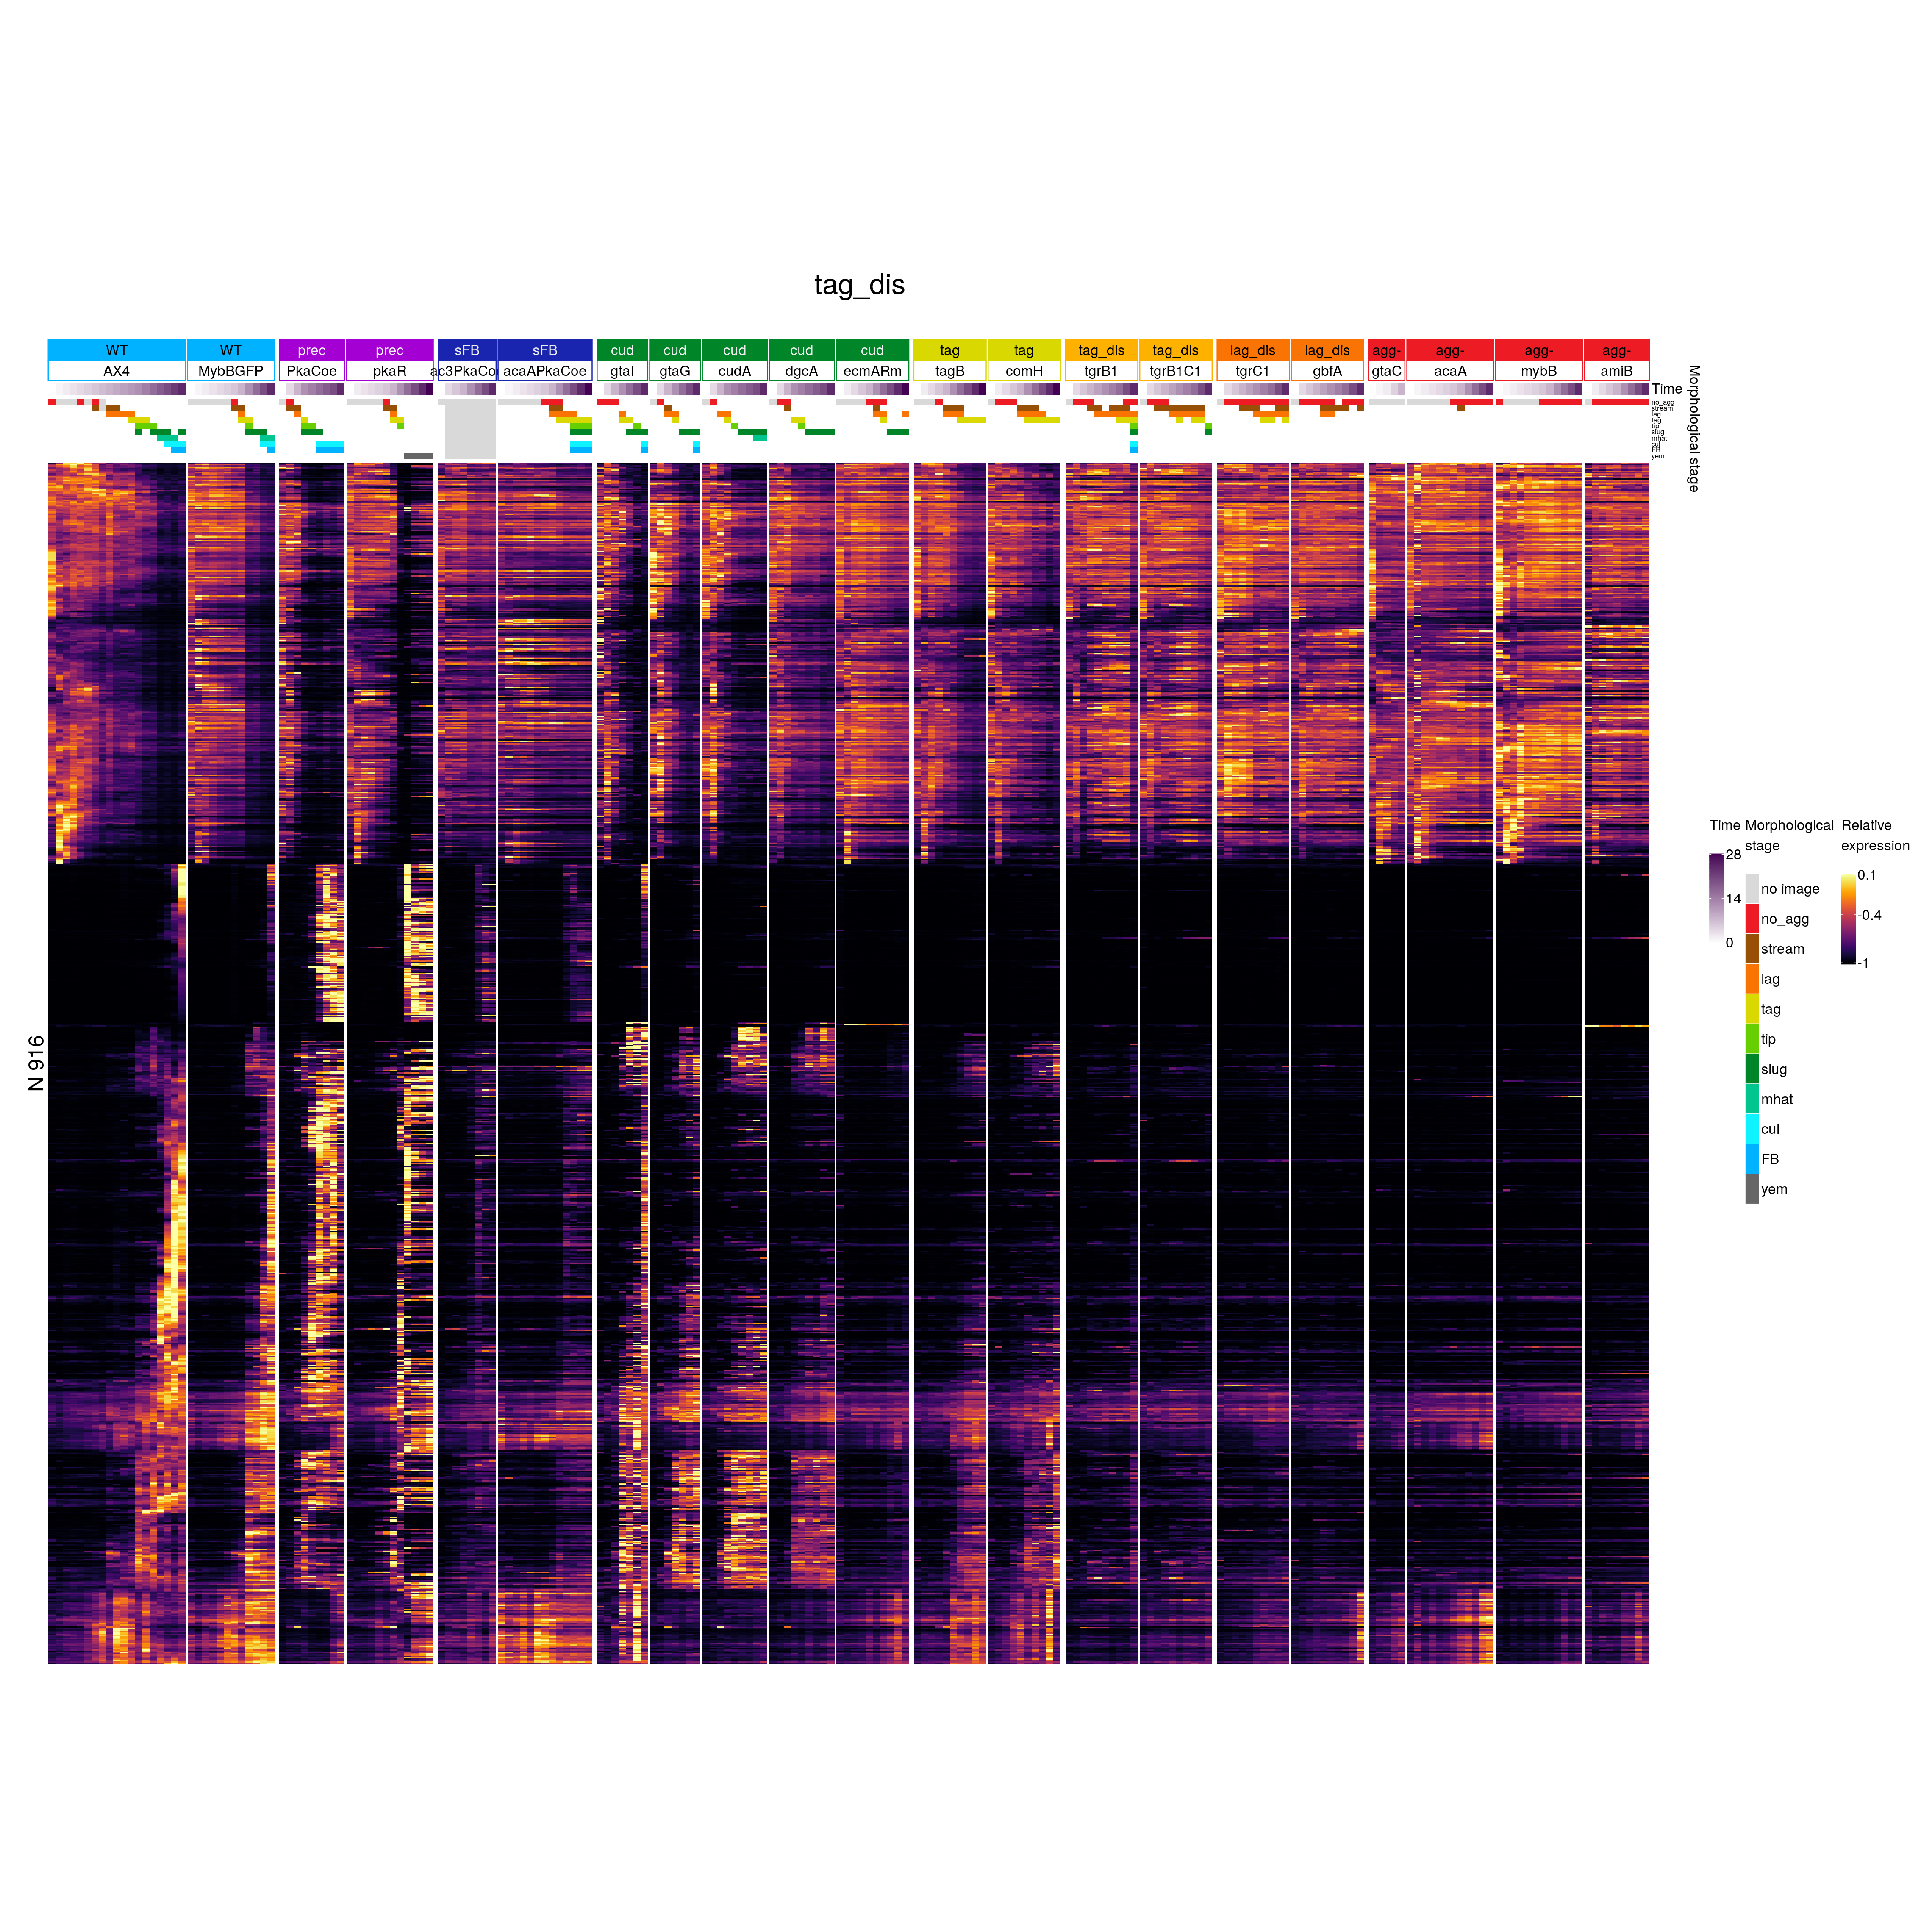

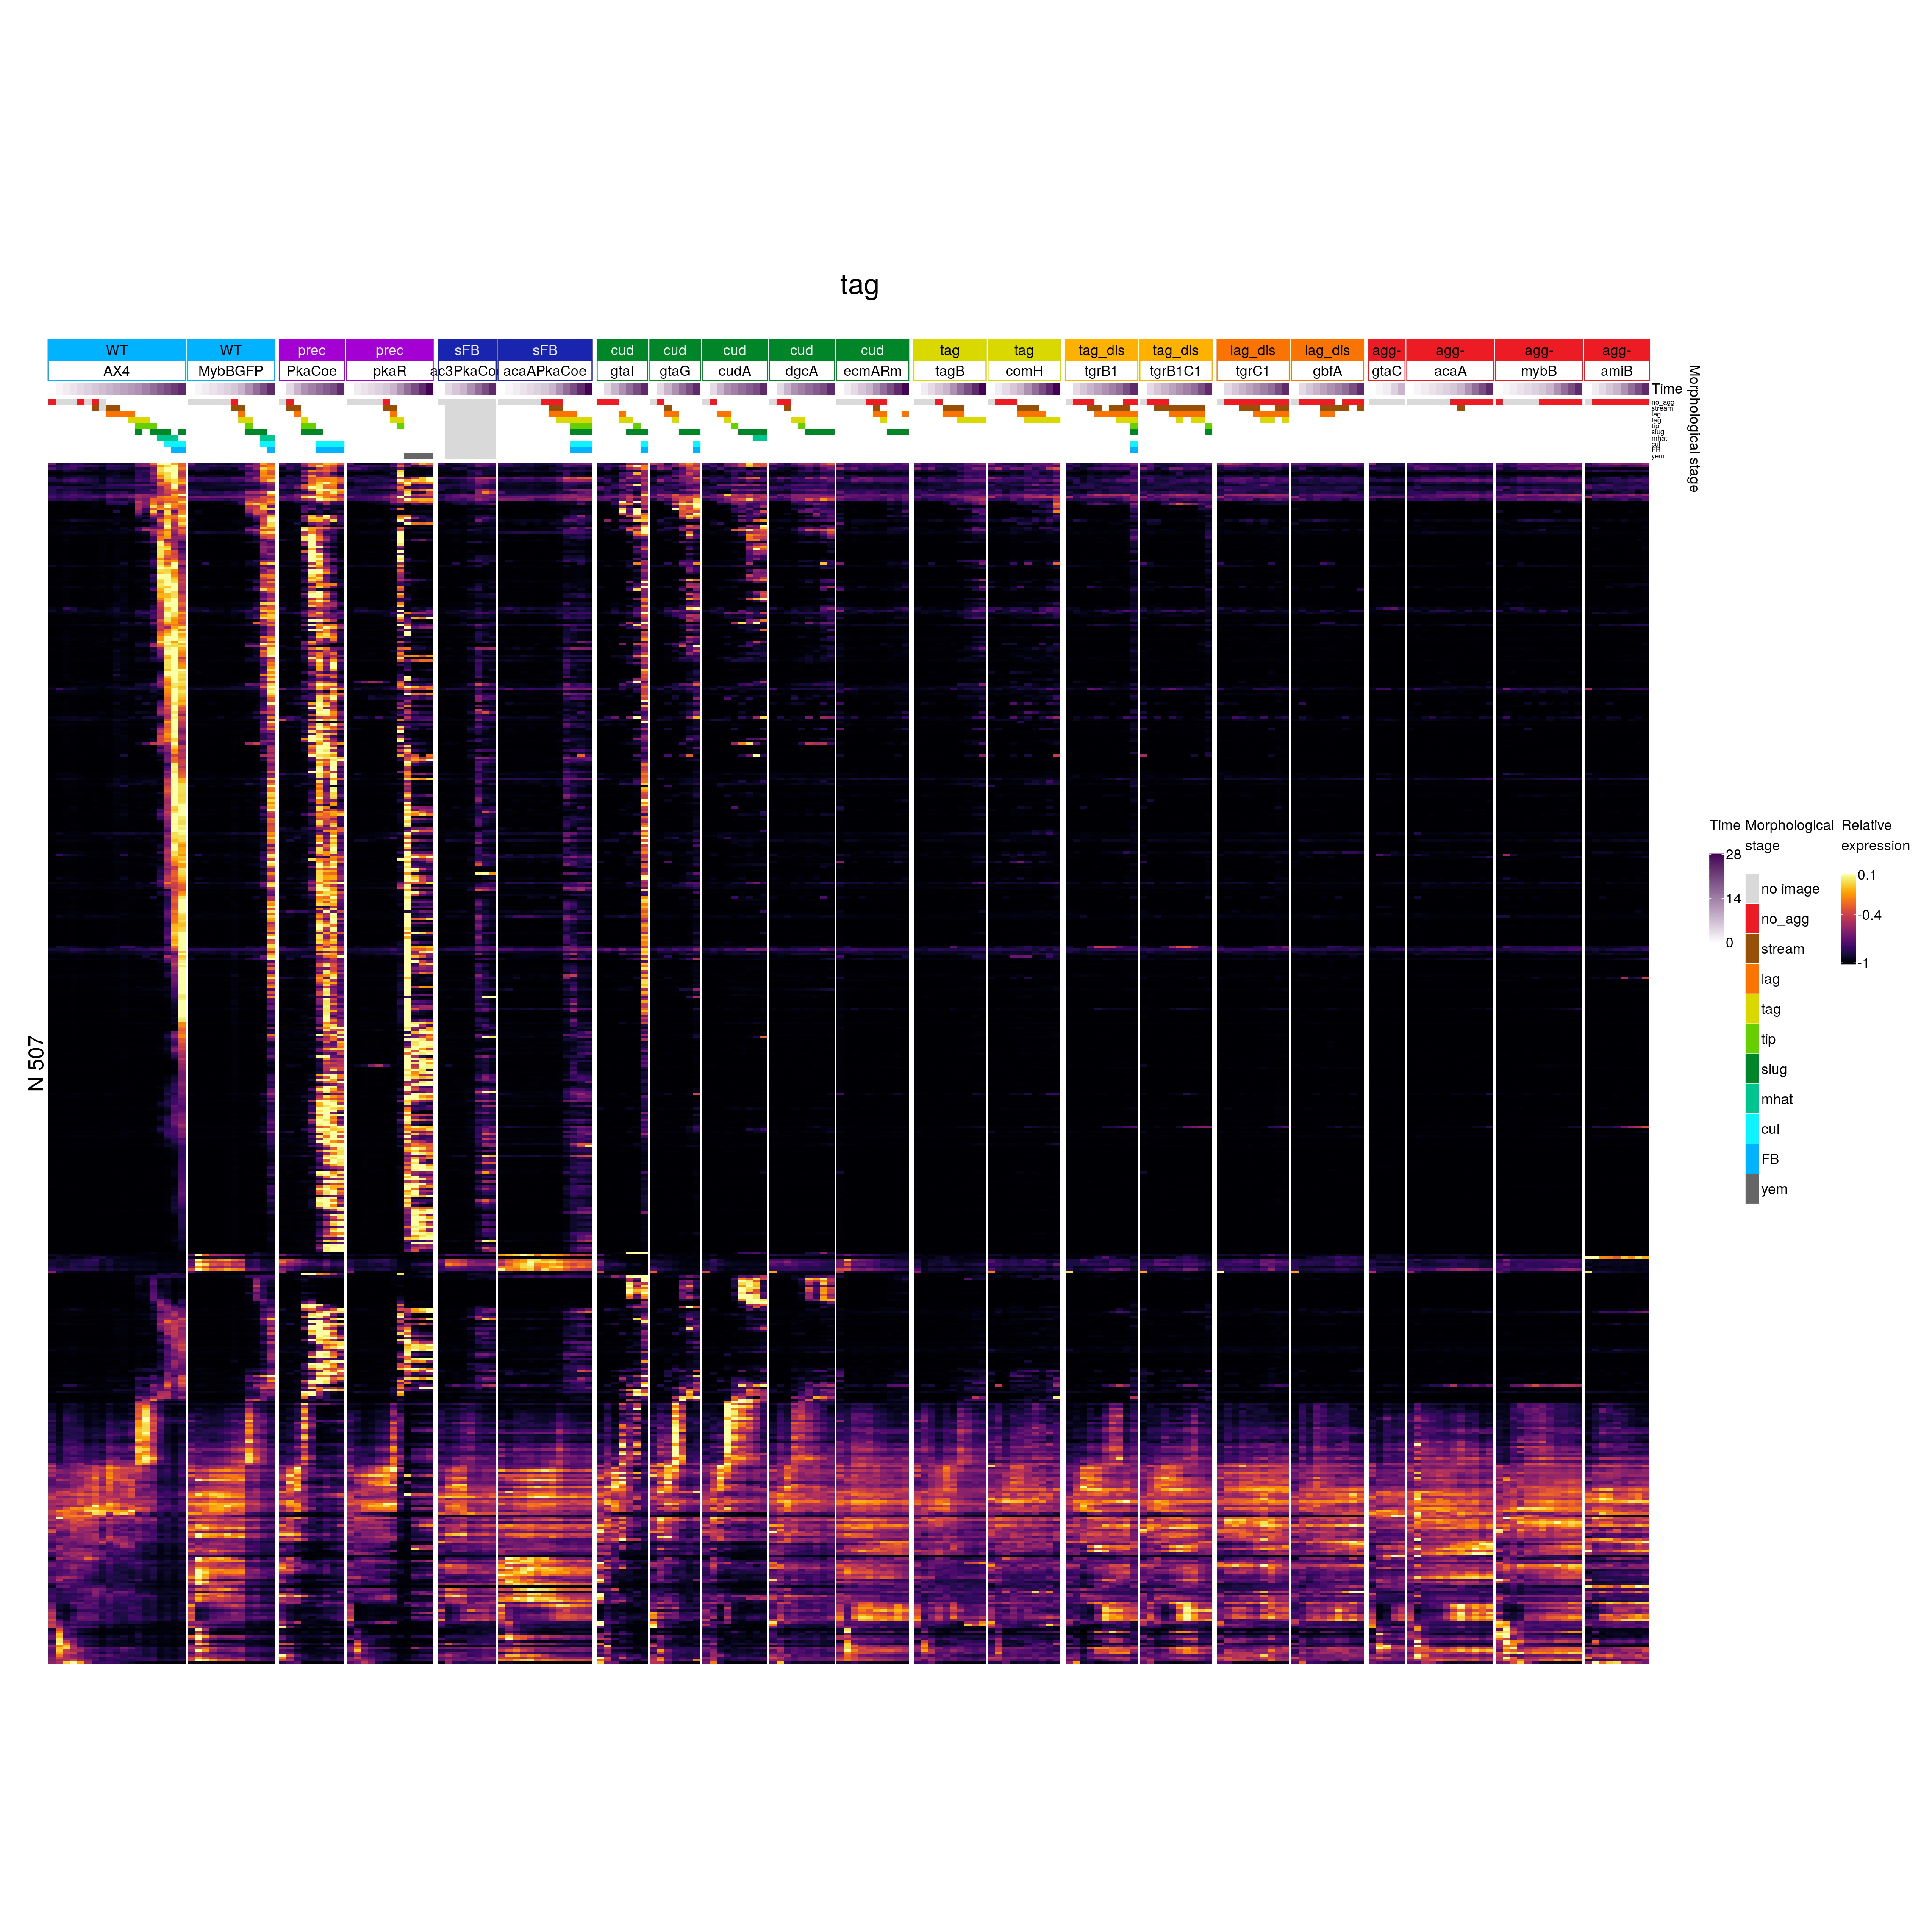

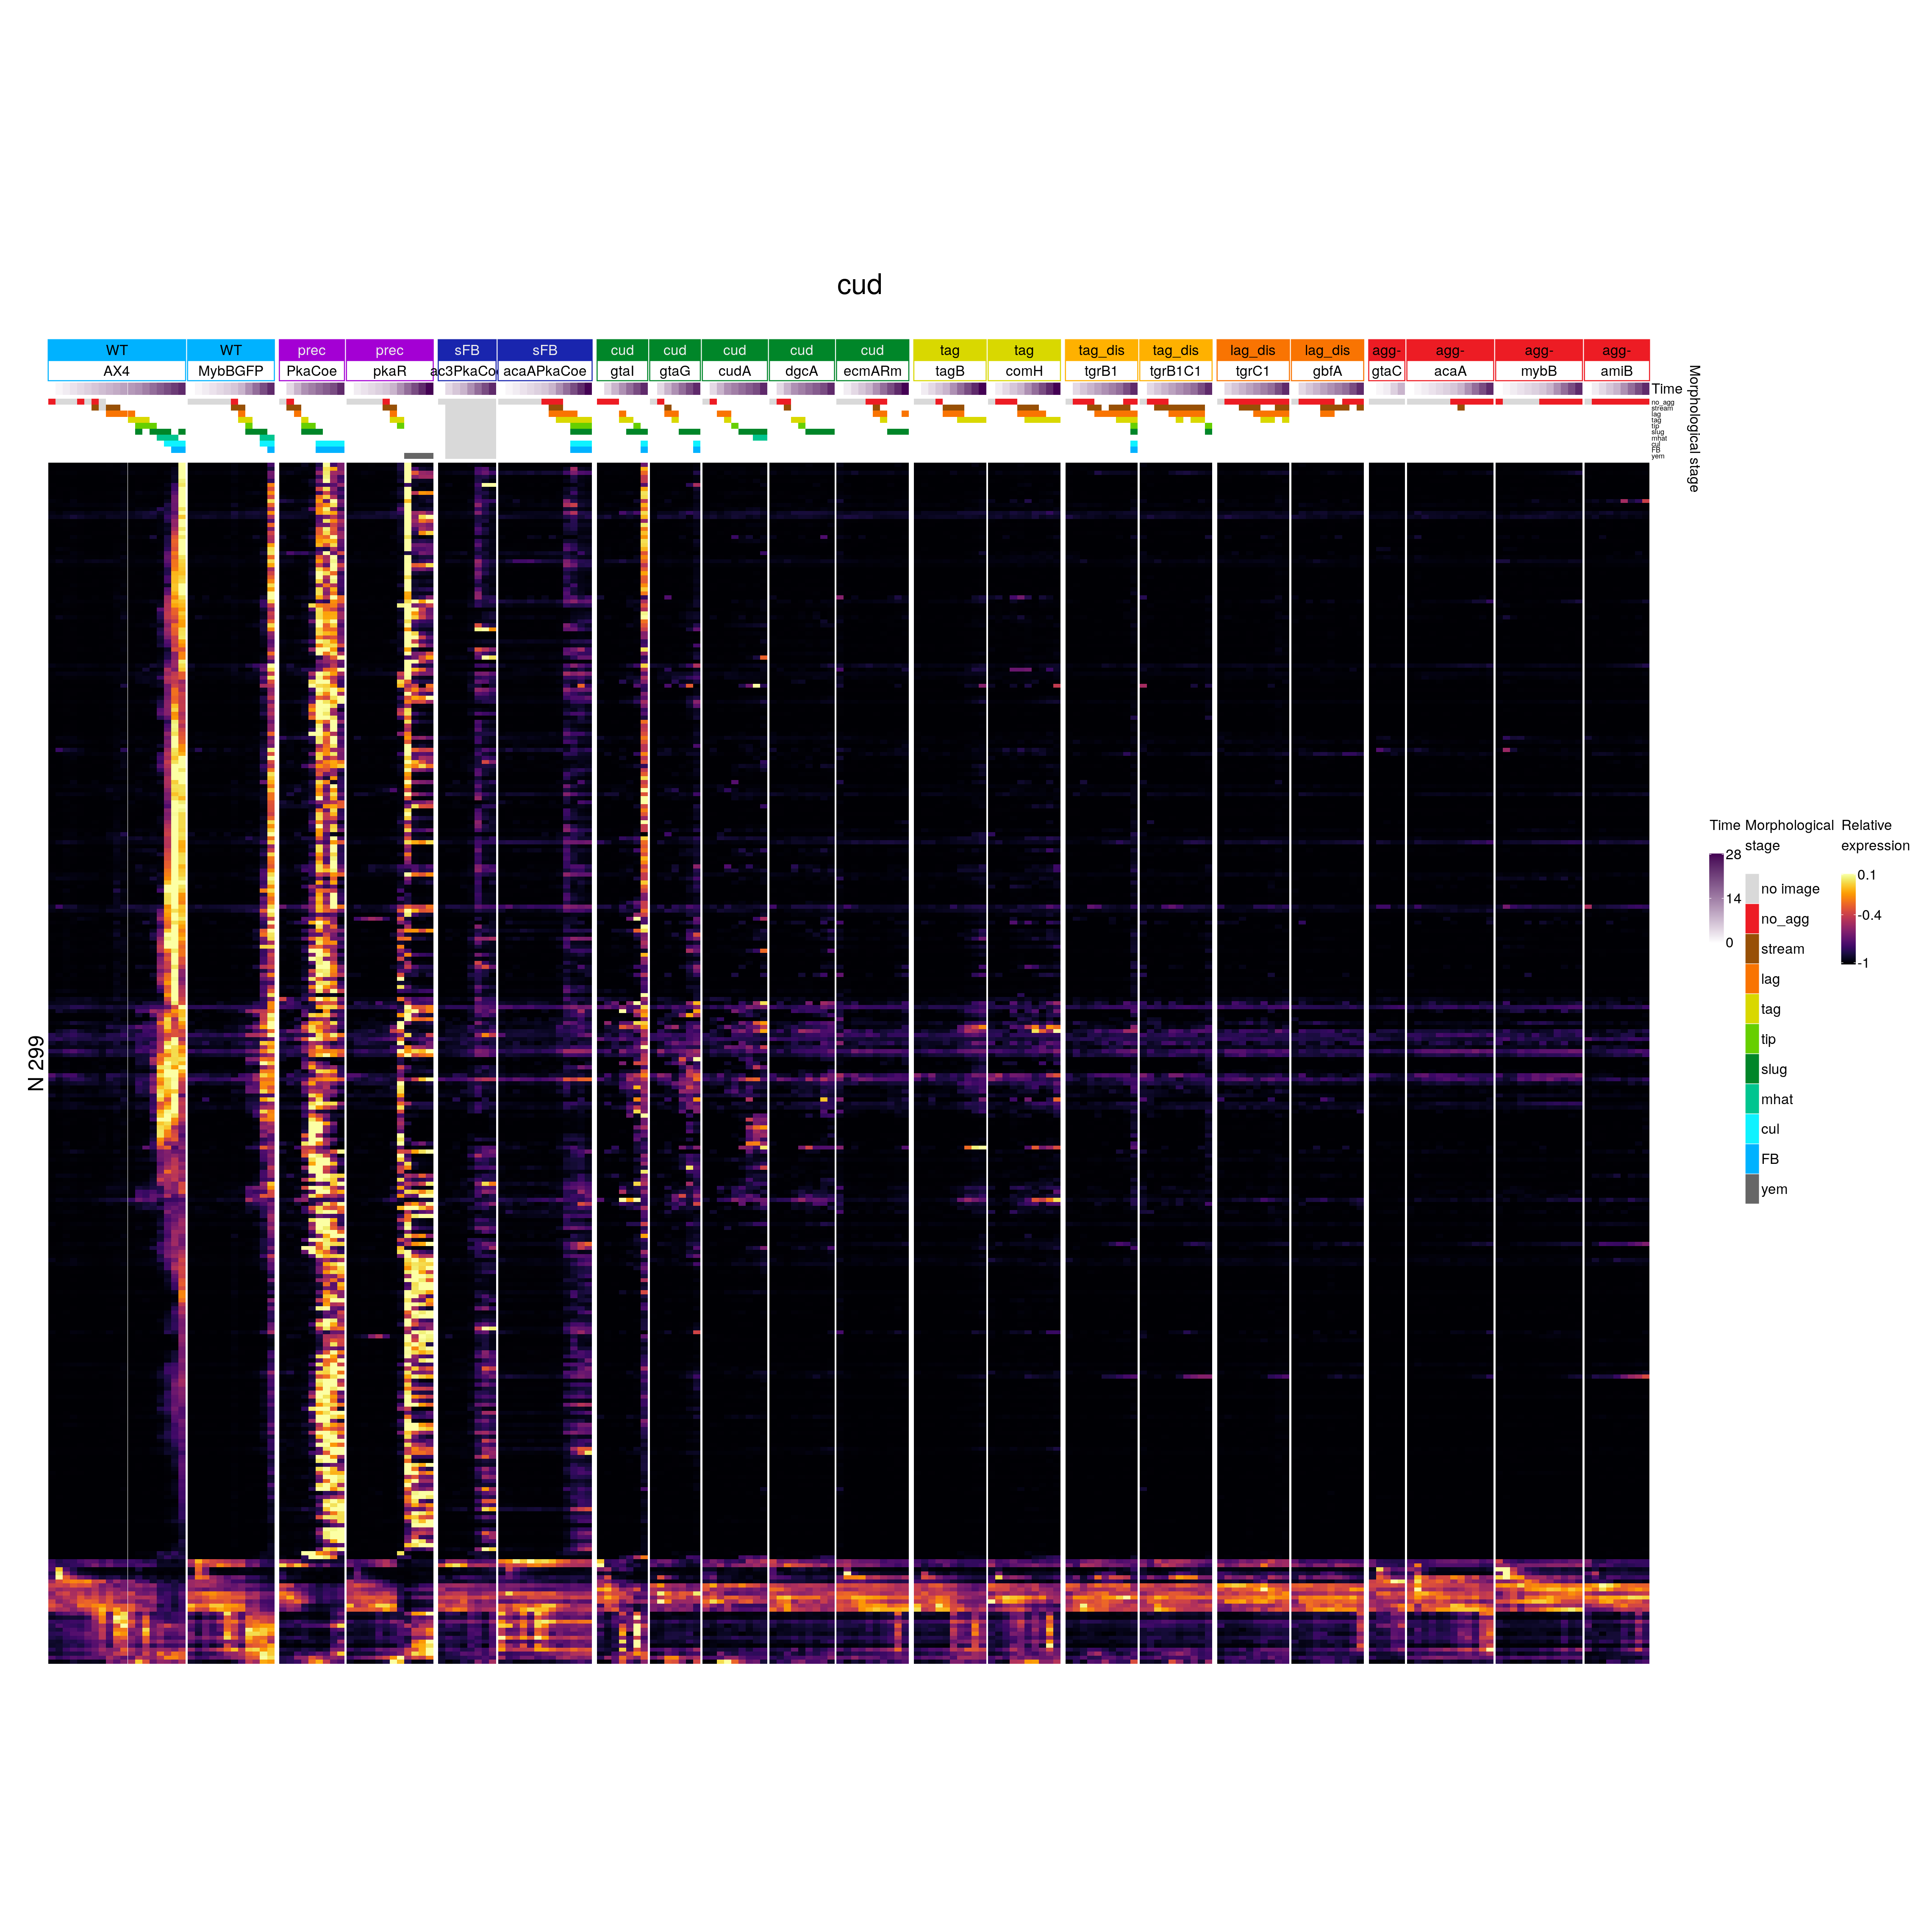

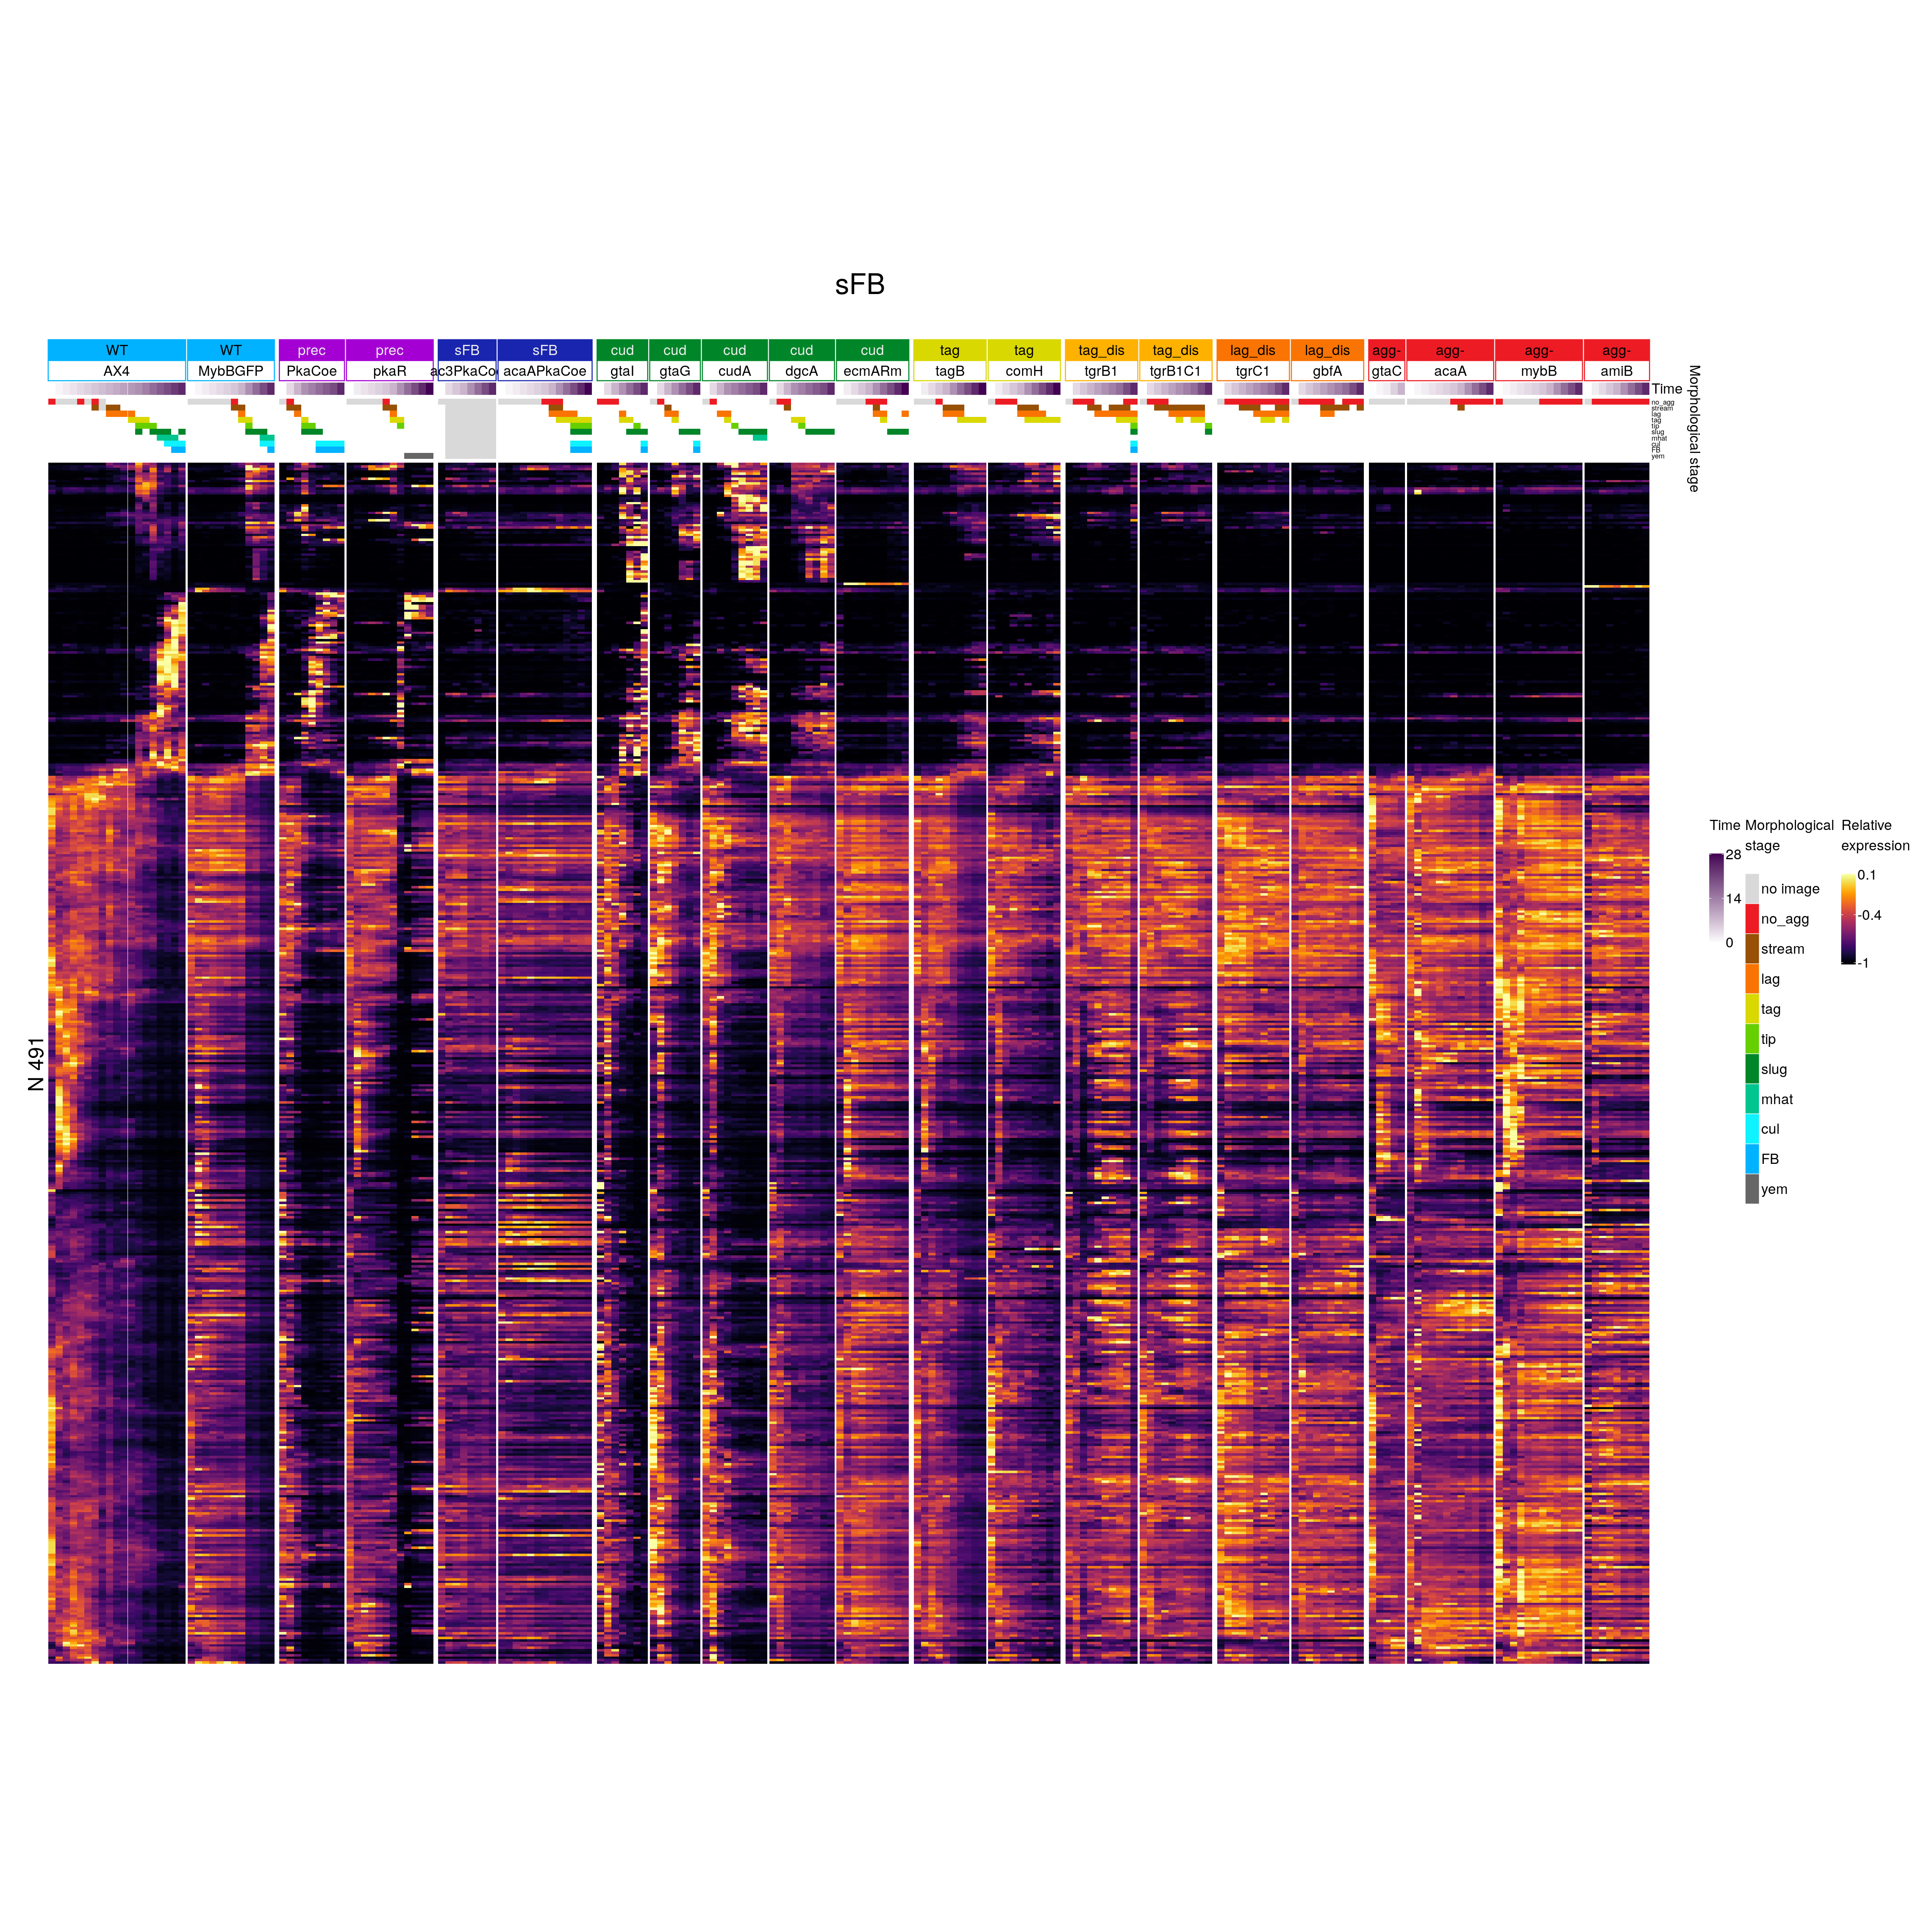

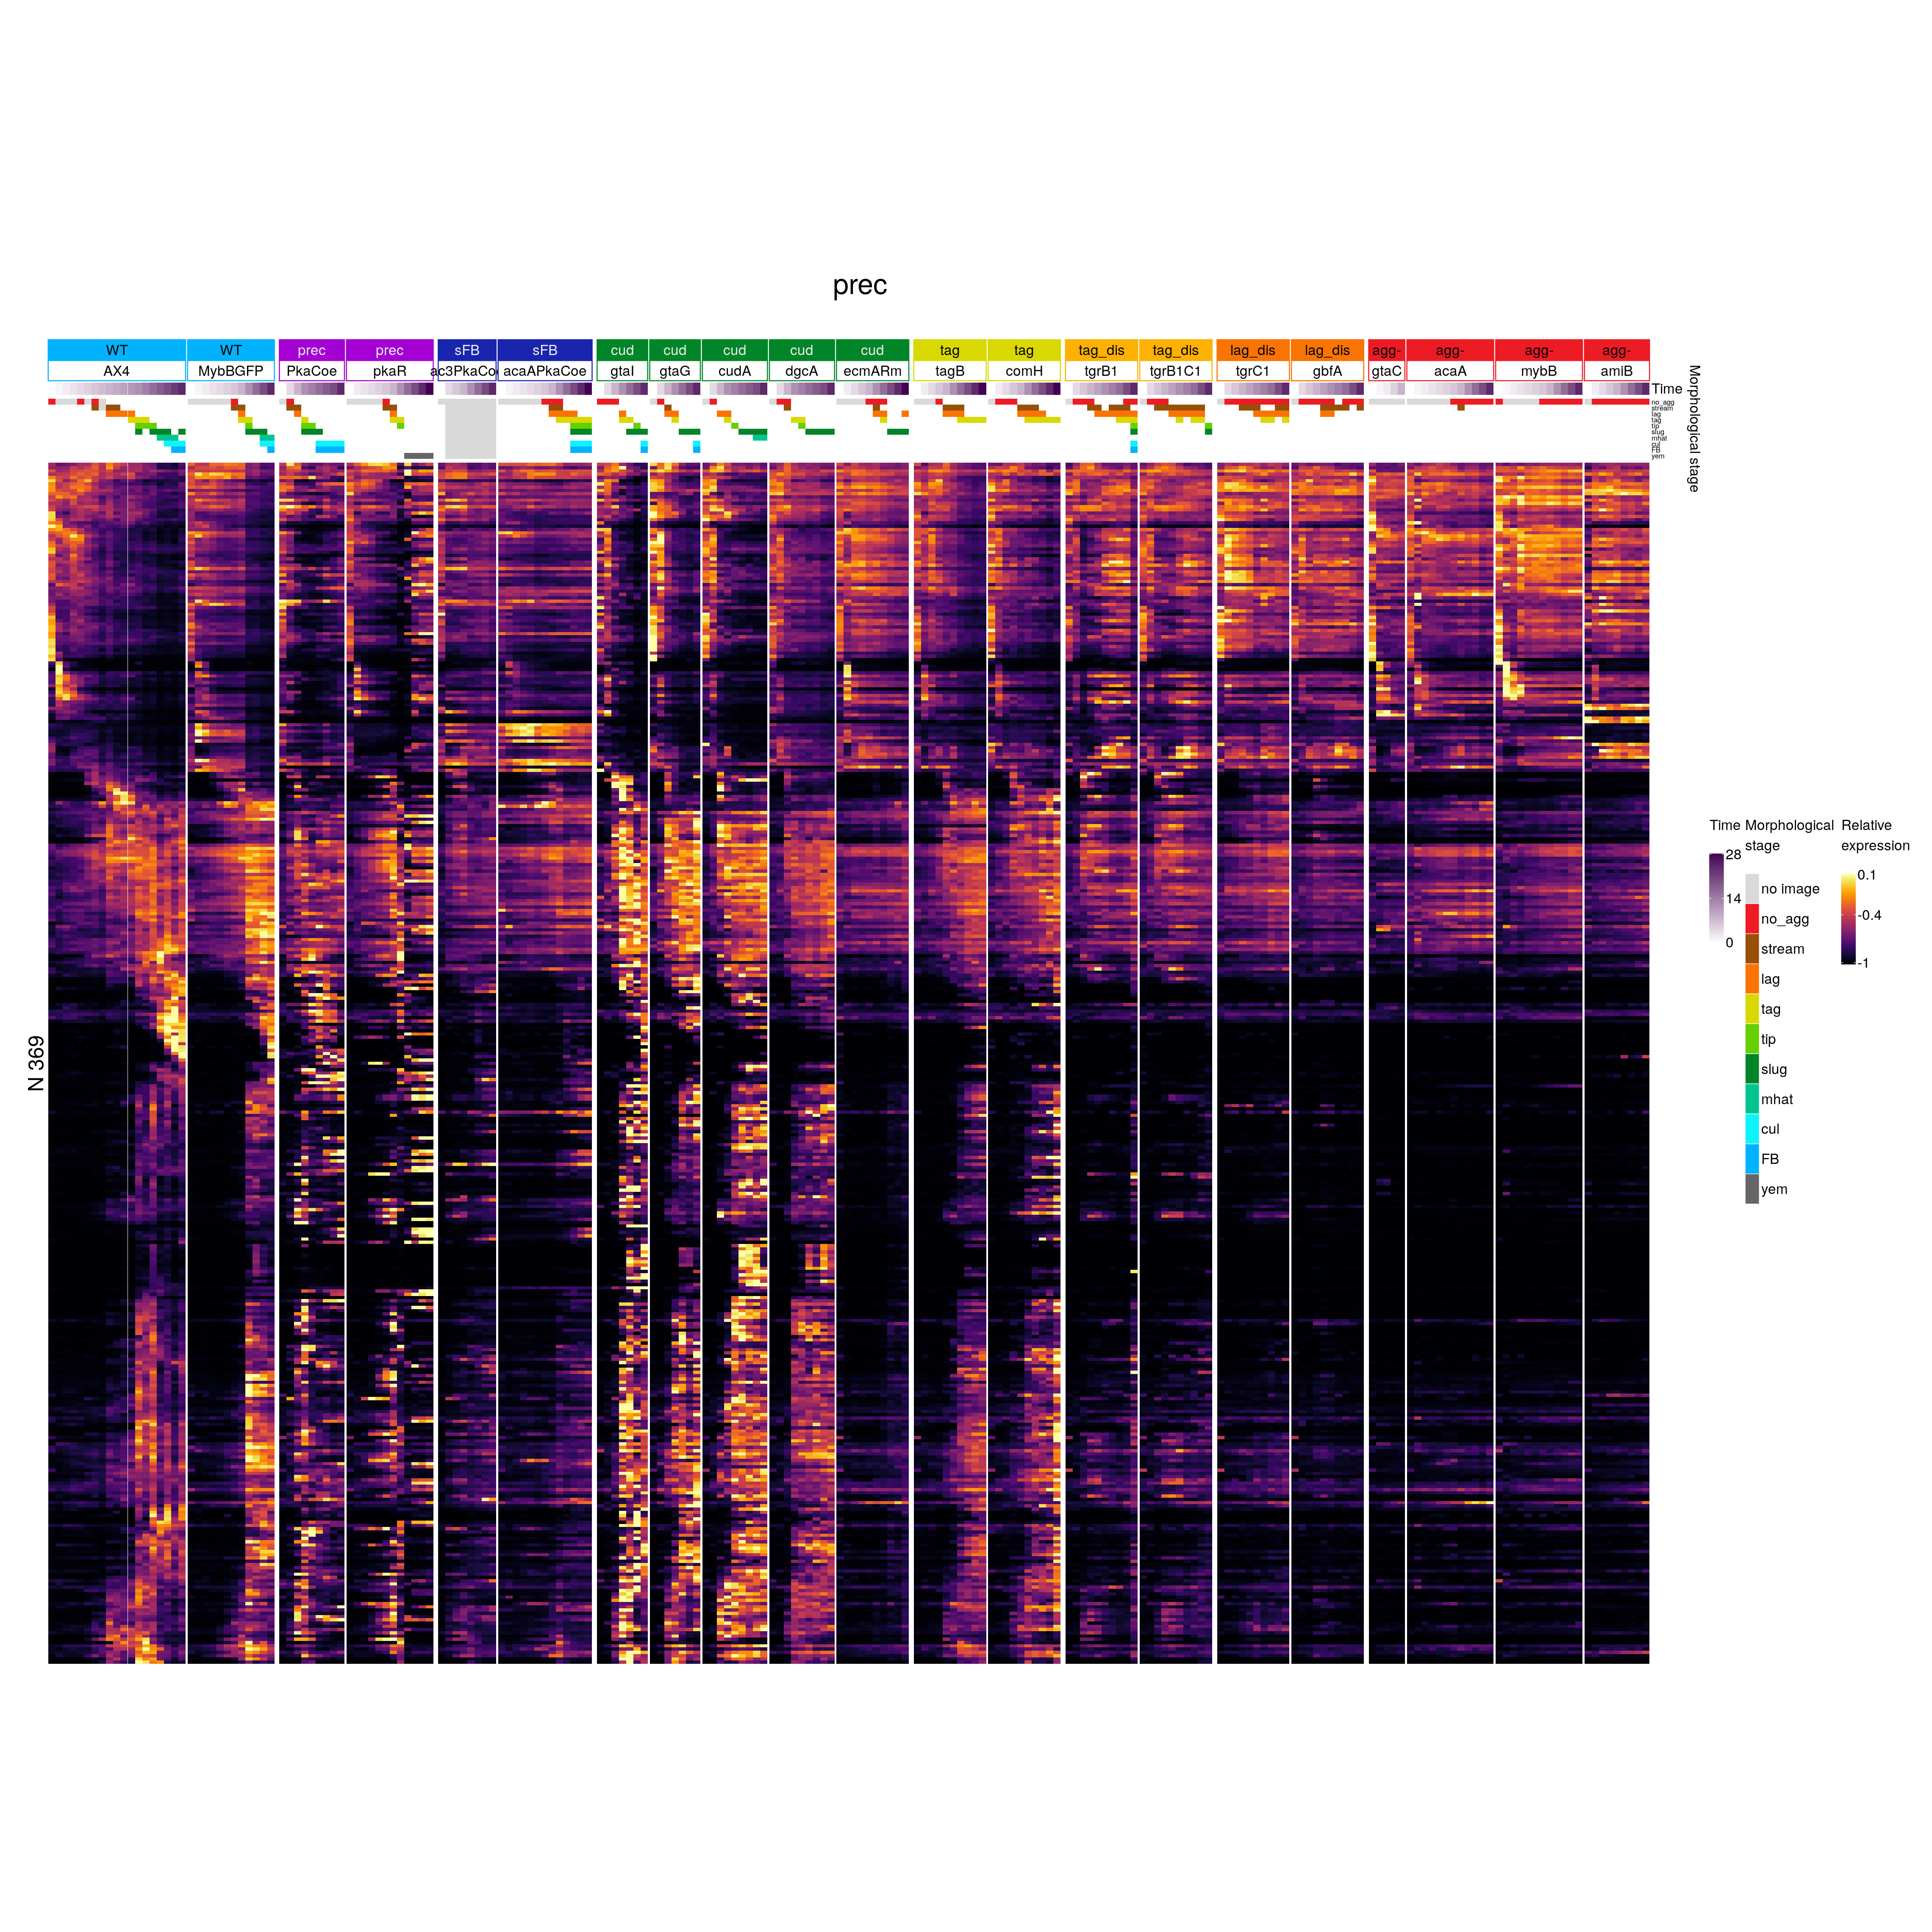

In [17]:
group_abberant<-list()
strain_groups<-c('agg-','lag_dis','tag_dis','tag','cud','sFB','prec')
for (group in strain_groups){
    data=read.table(paste0(path_abberant,'comparisonsSims_',group,
                           '_AX4basedNeigh_u-less_removeZeroRep_scalemean0std1_logTrue_kN11.tsv'),
                    header=TRUE,sep='\t')
    genes<-as.vector(data[data$FDR<=FDR & data['Difference.median']>=MEDIFF,'Gene'])
    n_genes=length(genes)
    group_abberant[[group]]<-genes
    
    expression=t(avg_expression[avg_expression$Strain=='AX4',genes])
    distances<-dist(expression, method="Euclidean")
    hc<-hclust(d=distances, method = "ward.D2" )
    hc_ordered<-reorder(x=hc,dist = distances)
    genes<- as.dendrogram(hc_ordered) %>% labels

    data_anno=paste('N',n_genes)
    height=1*n_genes
    if (height>60) height=60
    heatmap=Heatmap(t(avg_expression[,genes]),cluster_columns = FALSE,cluster_rows = FALSE,
                    show_column_names = FALSE,
                      show_row_names = FALSE, col=viridis(256),column_title=NULL, 
                      row_title=data_anno,
                      show_heatmap_legend = TRUE,heatmap_legend_param = list(
                      title = "\nRelative \nexpression\n",
                      at = c(min_expression, round(mean(c(min_expression,max_expression)),1),max_expression),
                      grid_width= unit(legend_width, "cm"),grid_height= unit(legened_height, "cm") ,
                      labels_gp = gpar(fontsize = cluster_font),title_gp = gpar(fontsize = cluster_font)),
                      #** Cluster name fontsize
                      row_title_gp=gpar(fontsize=cluster_font*1.5),height=unit(height, "cm"))

    draw(make_anno() %v% heatmap,width=unit(80, "cm"),
        column_title =paste(group,'\n'),column_title_gp = gpar(fontsize = cluster_font*2))

}

## Similarity between abberantly expressed genes in different strain groups

In [66]:
group_abberant<-list()
strain_groups<-c('agg-','lag_dis','tag_dis','tag','cud','sFB','prec')
for (group in strain_groups){
    data=read.table(paste0(path_abberant,'comparisonsSims_',group,
                           '_AX4basedNeigh_u-less_removeZeroRep_scalemean0std1_logTrue_kN11.tsv'),
                    header=TRUE,sep='\t')
    genes<-as.vector(data[data$FDR<=0.01 & data['Difference.median']>=0.2,'Gene'])
    n_genes=length(genes)
    group_abberant[[group]]<-genes
    
}

In [58]:
jaccard<-function(s1,s2){
    return(length(intersect(s1,s2))/length(union(s1,s2)))
}
proportion_smaller<-function(s1,s2){
    return(length(intersect(s1,s2))/min(length(s1),length(s2)))
}

In [ ]:
n_groups<-length(strain_groups)
group_overlap<-matrix(,nrow=n_groups,ncol=n_groups)
for(i in 1:(n_groups-1)){
    for(j in (1+i):n_groups){
        group_overlap[i,j]=jaccard(group_abberant[[strain_groups[i]]],group_abberant[[strain_groups[j]]])
    }
}
colnames(group_overlap)<-strain_groups
rownames(group_overlap)<-strain_groups

options(repr.plot.width=5, repr.plot.height=4)
Heatmap(group_overlap,cluster_columns = FALSE,cluster_rows = FALSE,col = viridis(256))

Below is shown overlap between gene list pairs normalised by the size of the smaller list. 

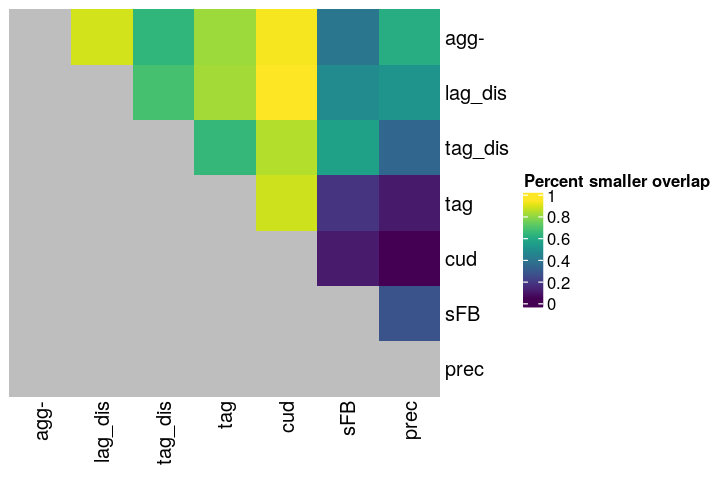

In [141]:
n_groups<-length(strain_groups)
group_overlap<-matrix(,nrow=n_groups,ncol=n_groups)
for(i in 1:(n_groups-1)){
    for(j in (1+i):n_groups){
        group_overlap[i,j]=proportion_smaller(group_abberant[[strain_groups[i]]],group_abberant[[strain_groups[j]]])
    }
}
colnames(group_overlap)<-strain_groups
rownames(group_overlap)<-strain_groups

options(repr.plot.width=6, repr.plot.height=4)
Heatmap(group_overlap,cluster_columns = FALSE,cluster_rows = FALSE,
        col = viridis(256),heatmap_legend_param = list(title = "Percent smaller overlap"))

In [133]:
all_abberant<-NULL
for(group in strain_groups){
    genes<-group_abberant[[group]]
    df<-data.frame('Gene'=genes,group=rep(1,(length(genes))))
    colnames(df)<-c('Gene',group)
    if(is.null(all_abberant)){
        all_abberant<-df
    }else{
        all_abberant<-merge(all_abberant,df,by='Gene',all=TRUE)
    }
}

all_abberant[is.na(all_abberant)]<-0
rownames(all_abberant)<-all_abberant$Gene
all_abberant=all_abberant[,-1]

Heatmap showing which gene was selected as abberantly expressed in each group (black) or not (white).

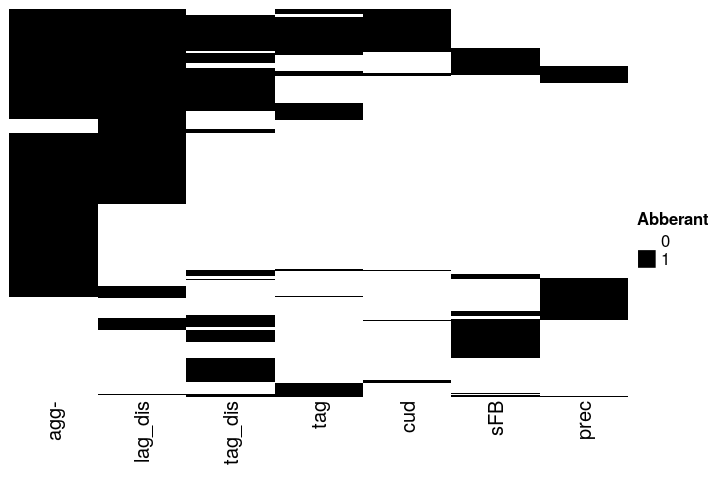

In [142]:
distances<-dist(all_abberant, method="Euclidean")
hc<-hclust(d=distances, method = "ward.D2" )
hc_ordered<-reorder(x=hc,dist = distances)
genes<- as.dendrogram(hc_ordered) %>% labels
Heatmap(as.matrix(all_abberant[genes,]),cluster_columns = FALSE,cluster_rows = FALSE,
        col = c('white','black'),show_row_names = FALSE,heatmap_legend_param = list(title = "Abberant"))

In [145]:
write.table(all_abberant[genes,],paste0(path_abberant,'comparisonsSimsGenes_FDR',FDR,'MeDiff',MEDIFF,
            '_AX4basedNeigh_u-less_removeZeroRep_scalemean0std1_logTrue_kN11.tsv'),
            sep='\t',col.names=NA)

## Conclusion
Interesting things to look at:
- Groups agg- to cud have relatively similar genes (as proportion of selected gene overlap in two groups compared to the size of the smaller group). This might correspond to progressive arrest of these groups - more developped groups having less abberantly expressed genes.  This does not seem to be so for sFB and prec.
- sFB has relativey many abberantly expressed genes that seem to be characteristic of early development and non-reproductive state.
- prec heatmap shows set of early developmental/vegetative genes that get re-activated in yem. 

Things to improve:
- The comparison between mutant groups is currently based on threshold filtering and not statistical tests (the test is performed only between uindividual mutant groups and WT). To figure out if genes are really specifically aberrant in some groups further tests should be performed.
- Gene similarities are quantile normalised in strains to make them comparable across strains. However, this is problematic as some strain groups (e.g. agg-) are expected to have smaller N of high similarities and quantile normalisation forces some genes to be given too high similarities. This could lead to false negatives when searching for genes with smaller similarities in these groups. 